In [1]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

2024-09-17 19:01:12.680744: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
mp_pose = mp.solutions.pose

pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=2)

mp_drawing = mp.solutions.drawing_utils 

In [3]:
def detectPose(image, pose, display=True):

    output_image = image.copy()
    
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    results = pose.process(imageRGB)
    
    height, width, _ = image.shape
    
    landmarks = []
    
    if results.pose_landmarks:
    
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        for landmark in results.pose_landmarks.landmark:
            
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    if display:
    
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        
    else:
        
        return output_image, landmarks

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


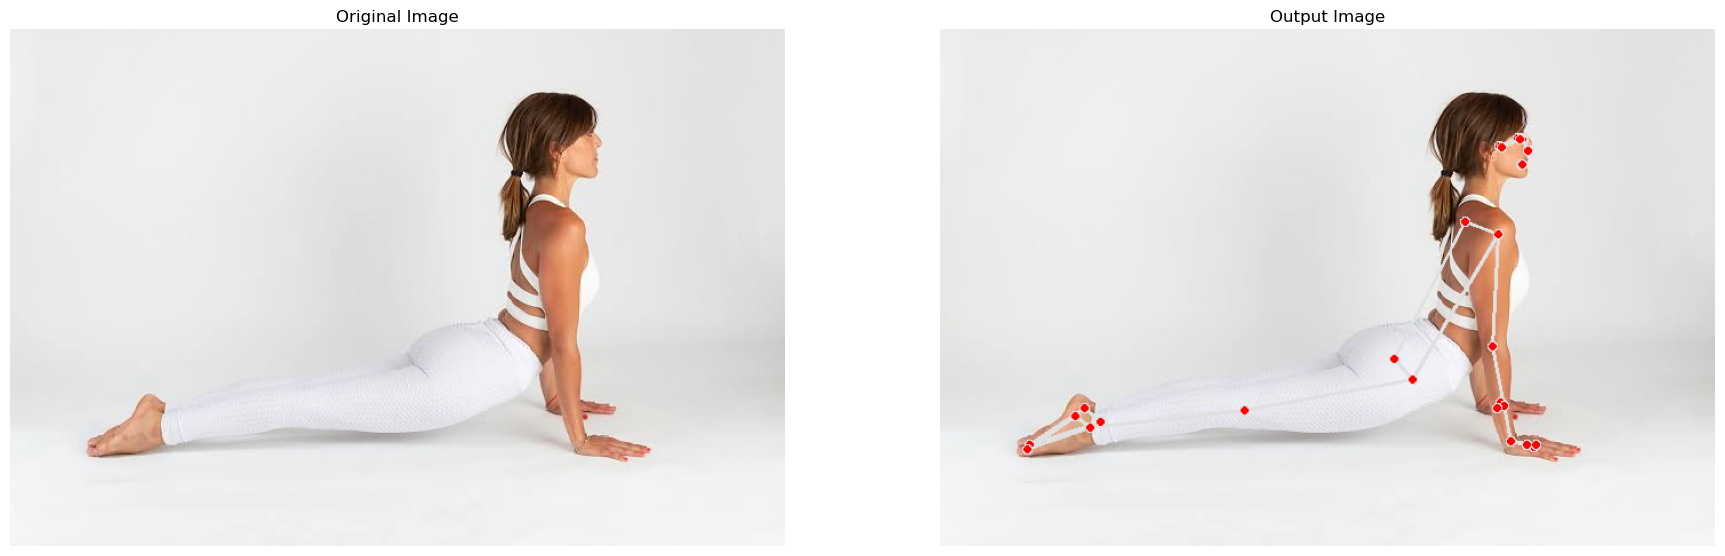

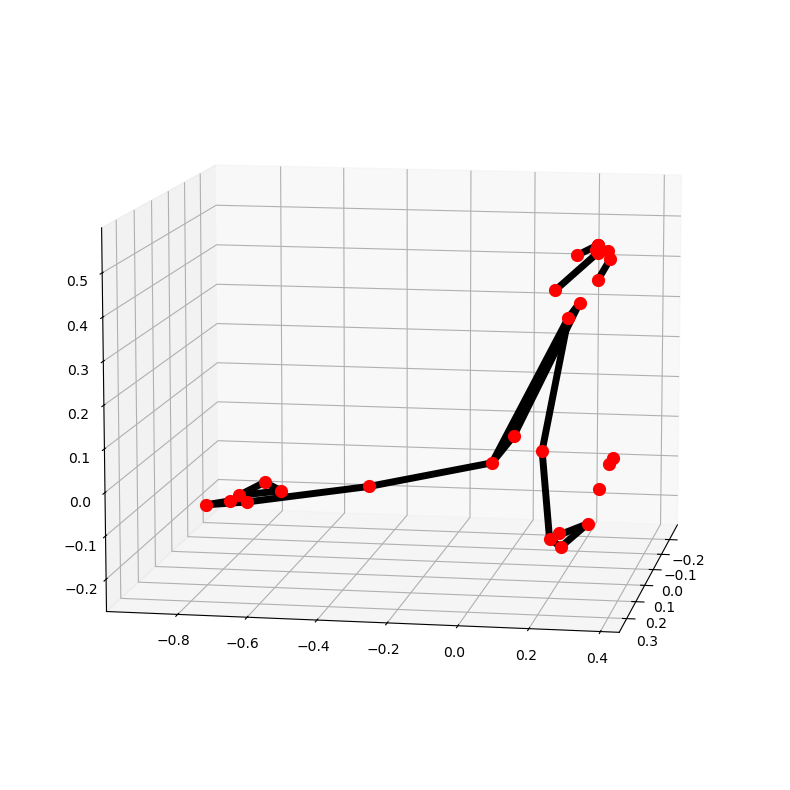

In [4]:
image = cv2.imread('media/IMG_6434.jpg')
detectPose(image, pose, display=True)

In [5]:
def calculateAngle(landmark1, landmark2, landmark3):
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3

    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    
    if angle < 0:

        angle += 360
    
    return angle

In [6]:
pose_start_time = None
total_hold_time = 0
correct_pose = False

def classifyPose(landmarks, output_image, target_pose, display=False):
    global correct_pose
    label = 'Unknown Pose'
    color = (0, 0, 255)
    
    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])   
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    left_hip_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                    landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                    landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value])
    right_hip_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                     landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value])
    
    if target_pose == 'Cobra Pose':
        if (150 <= left_knee_angle <= 210 and 150 <= right_knee_angle <= 210 and
            ((85 <= left_hip_angle <= 125 or 220 <= left_hip_angle <= 260) and
            (85 <= right_hip_angle <= 125 or 220 <= right_hip_angle <= 230))):
            label = 'Cobra Pose'
    
    if target_pose == 'Warrior II Pose':
        if left_elbow_angle > 165 and left_elbow_angle < 195 and right_elbow_angle > 165 and right_elbow_angle < 195:
            if left_shoulder_angle > 80 and left_shoulder_angle < 110 and right_shoulder_angle > 80 and right_shoulder_angle < 110:
                if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:
                    if left_knee_angle > 60 and left_knee_angle < 150 or right_knee_angle > 60 and right_knee_angle < 150:
                        label = 'Warrior II Pose'
    
    if target_pose == 'T Pose':
        if left_elbow_angle > 165 and left_elbow_angle < 195 and right_elbow_angle > 165 and right_elbow_angle < 195:
            if left_shoulder_angle > 80 and left_shoulder_angle < 110 and right_shoulder_angle > 80 and right_shoulder_angle < 110:
                if left_knee_angle > 160 and left_knee_angle < 195 and right_knee_angle > 160 and right_knee_angle < 195:
                    label = 'T Pose'
    
    if target_pose == 'Tree Pose':
        if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:
            if left_knee_angle > 315 and left_knee_angle < 335 or right_knee_angle > 25 and right_knee_angle < 45:
                label = 'Tree Pose'

    if label == target_pose:
        correct_pose = True
        color = (0, 255, 0)
    else:
        correct_pose = False

    cv2.putText(output_image, label, (10, 30), cv2.FONT_HERSHEY_PLAIN, 2, color, 2)
    return output_image, label

def update_timer():
    global pose_start_time, total_hold_time, correct_pose
    if correct_pose:
        if pose_start_time is None:
            pose_start_time = time()
        else:
            total_hold_time += time() - pose_start_time
            pose_start_time = time()  
    else:
        pose_start_time = None

pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

camera_video = cv2.VideoCapture(0)
camera_video.set(3, 1280)
camera_video.set(4, 960)

cv2.namedWindow('Pose Classification', cv2.WINDOW_NORMAL)

target_pose = input("Enter the pose you want to practice (e.g., 'Tree Pose', 'Warrior II Pose', 'T Pose', 'Cobra Pose'): ")

while camera_video.isOpened():
    ok, frame = camera_video.read()
    if not ok:
        continue
    frame = cv2.flip(frame, 1)
    frame_height, frame_width, _ = frame.shape
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
    frame, landmarks = detectPose(frame, pose_video, display=False)
    
    if landmarks:
        frame, _ = classifyPose(landmarks, frame, target_pose, display=False)
        update_timer()
        
        cv2.putText(frame, f"Hold Time: {int(total_hold_time)} sec", (10, 60), cv2.FONT_NOT_HERSHEY, 2, (255, 0, 0), 2)
    
    cv2.imshow('Pose Classification', frame)
    
    if cv2.waitKey(1) & 0xFF == 27:
        break

camera_video.release()
cv2.destroyAllWindows()


Enter the pose you want to practice (e.g., 'Tree Pose', 'Warrior II Pose', 'T Pose', 'Cobra Pose'):  T Pose


AttributeError: module 'cv2' has no attribute 'FONT_NOT_HERSHEY'